# Getting Started

In this notebook, we will walk you through a minimal example for candidate generation and re-reranking with the [Quaero](https://quaerofrenchmed.limsi.fr/) corpus.

## Preparation

Go to the root folder of the repository and run the following commands

`xmen dict conf/quaero.yaml`

This command creates the Quaero-specific UMLS subset as a jsonl file.
If you don't have access to UMLS metathesaurus 2014AB release, you can adapt the yaml file to point to any other release.

`xmen index conf/quaero.yaml --sapbert`

This command creates the FAISS index of SapBERT embeddings for candidate generation.

By default, all files are written to `~/.cache/xmen`, unless configured otherwise.

## Loading Knowledge Base and Dataset

In [1]:
from pathlib import Path
base_path = Path.home() / ".cache/xmen/quaero"

In [3]:
# Load knowledge base
from xmen import load_kb
kb = load_kb(base_path / "quaero.jsonl")

FileNotFoundError: [Errno 2] No such file or directory: '/dhc/home/florian.borchert/.cache/xmen/quaero/quaero.jsonl'

In [4]:
# Load Quaero MEDLINE subset through BigBIO dataloader
from datasets import load_dataset
dataset = load_dataset("bigbio/quaero", "quaero_medline_bigbio_kb")

Found cached dataset quaero (/home/Florian.Borchert/.cache/huggingface/datasets/bigbio___quaero/quaero_medline_bigbio_kb/1.0.0/c215a01af5fd15163e392e2f78a4f67f1fe3567d92f53b7f907c95e55dcdfe93)


  0%|          | 0/3 [00:00<?, ?it/s]

# Candidate Generation

We use the pre-computed FAISS index to retrieve the most similar concepts in the cross-lingual SapBERT embedding space

In [5]:
# Generate candidates with cross-lingual SapBERT
from xmen.linkers import *

linker = SapBERTLinker(index_base_path=base_path / "index" / "sapbert", k=1000)

[06/01/23 11:30:20] INFO     Loading hierarchical faiss index                                ]8;id=794760;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=719136;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/sap_bert_linker.py#148\148]8;;\

                    INFO     Loading index from                                                 ]8;id=323004;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=135436;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py#64\64]8;;\
                             /home/Florian.Borchert/.cache/xmen/quaero/index/sapbert/embed_fais                    
                             s_hier.pickle                                                                         

[06/01/23 11:30:28] INFO     Loaded index of type <class 'faiss.swigfaiss.IndexHNSWFlat'> and   ]8;id=37270;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=396295;file:///home/Florian.Borchert/miniconda3/envs/xmen_notebooks/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py#66\66]8;;\
                             size 6910830                                                                          

In [6]:
candidates = linker.predict_batch(dataset, batch_size=128)

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [7]:
from xmen.evaluation import *

evaluate(dataset['test'], candidates['test'], top_k_predictions=1)

{'strict': {'precision': 0.6154342912495964,
  'recall': 0.6156330749354005,
  'fscore': 0.6155336670434362,
  'ptp': 1906,
  'fp': 1191,
  'rtp': 1906,
  'fn': 1190,
  'n_docs_system': 833,
  'n_annos_system': 3103,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

# Reranking

Finally, we train a cross-encoder to learn a better ranking from the training dataset.

Here, we consider batches of 64 candidates. The cross-encoder is trained for 3 epochs (you want to increase this for better performance). We keep the checkpoint that maximizes accuracy@1 on the validation set.

In [8]:
from xmen.linkers.util import filter_and_apply_threshold
candidates_64 = filter_and_apply_threshold(candidates, k=64, threshold=0.0)

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [9]:
from xmen.reranking.cross_encoder import *
ce_dataset = CrossEncoderReranker.prepare_data(candidates_64, dataset, kb)

Context length: 128


  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/2994 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/3103 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

  0%|          | 0/2977 [00:00<?, ?it/s]

In [11]:
# Train the cross-encoder on the training set and use the validation set for model selection
rr = CrossEncoderReranker()
args = CrossEncoderTrainingArgs(num_train_epochs=3)
rr.fit(args, ce_dataset["train"].dataset, ce_dataset["validation"].dataset)

model_name := bert-base-multilingual-cased
num_train_epochs := 3
fp16 := True
label_smoothing := False
score_regularization := False
train_layers := None
softmax_loss := True


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

2023-06-01 13:43:11 - Use pytorch device: cuda
Using score regularization: False
Using label smoothing factor: False


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2994 [00:00<?, ?it/s]

2023-06-01 14:13:47 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 0:
2023-06-01 14:33:54 - Accuracy: 0.6597245549210615
2023-06-01 14:33:54 - Accuracy @ 5: 0.8034934497816594
2023-06-01 14:33:54 - Accuracy @ 64: 0.8972119583473295
2023-06-01 14:33:54 - Baseline Accuracy: 0.6150487067517635
2023-06-01 14:33:54 - Save model to ./output/cross_encoder


Iteration:   0%|          | 0/2994 [00:00<?, ?it/s]

2023-06-01 15:04:33 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 1:
2023-06-01 15:24:39 - Accuracy: 0.6899563318777293
2023-06-01 15:24:39 - Accuracy @ 5: 0.8125629828686597
2023-06-01 15:24:39 - Accuracy @ 64: 0.8972119583473295
2023-06-01 15:24:39 - Baseline Accuracy: 0.6150487067517635
2023-06-01 15:24:39 - Save model to ./output/cross_encoder


Iteration:   0%|          | 0/2994 [00:00<?, ?it/s]

2023-06-01 15:55:18 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 2:
2023-06-01 16:15:24 - Accuracy: 0.6892845146120256
2023-06-01 16:15:24 - Accuracy @ 5: 0.8152502519314746
2023-06-01 16:15:24 - Accuracy @ 64: 0.8972119583473295
2023-06-01 16:15:24 - Baseline Accuracy: 0.6150487067517635


In [12]:
# Predict on test set
prediction = rr.rerank_batch(candidates_64["test"], ce_dataset["test"])

Batches:   0%|          | 0/3103 [00:00<?, ?it/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

# Evaluation

We compute metrics for the predicted concepts vs. the gold-standard for different values of k

In [13]:
evaluate(dataset['test'], prediction, top_k_predictions=1)

{'strict': {'precision': 0.7093961898611559,
  'recall': 0.709625322997416,
  'fscore': 0.7095107379299209,
  'ptp': 2197,
  'fp': 900,
  'rtp': 2197,
  'fn': 899,
  'n_docs_system': 833,
  'n_annos_system': 3103,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

In [15]:
for i in [1,2,4,8,16,32,64]:
    print(f'Recall@{i}', evaluate(dataset['test'], prediction, top_k_predictions=i)['strict']['recall'])

Recall@1 0.709625322997416
Recall@2 0.7822997416020672
Recall@4 0.8242894056847545
Recall@8 0.851421188630491
Recall@16 0.8837209302325582
Recall@32 0.9031007751937985
Recall@64 0.915374677002584


# Error Analysis

To gain more insights into the ranking errors (and potential NER errors, which do not apply here), we use `entity_linking_error_analysis`

In [27]:
# Before re-ranking
error_analysis = entity_linking_error_analysis(dataset['test'], candidates_64['test'])
error_analysis.head(10)

,pred_start,pred_end,pred_text,gt_start,gt_end,gt_text,entity_match_type,gold_concept,gold_type,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,0.0,5.0,[Etude],0.0,5.0,[Etude],tp,"{'db_name': 'UMLS', 'db_id': 'C0008972'}",PROC,-1.0,NaN,C1552232,0.795262,1009657
1,47.0,55.0,[Africain],47.0,55.0,[Africain],tp,"{'db_name': 'UMLS', 'db_id': 'C0027567'}",LIVB,1.0,0.863724,C1452383,0.865642,1009657
2,4.0,22.0,[gangrènes gazeuses],4.0,22.0,[gangrènes gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017105'}",DISO,0.0,0.935468,C0017105,0.935468,1009808
3,4.0,13.0,[gangrènes],4.0,13.0,[gangrènes],tp,"{'db_name': 'UMLS', 'db_id': 'C0017086'}",DISO,0.0,0.97305,C0017086,0.973050,1009808
4,14.0,22.0,[gazeuses],14.0,22.0,[gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017110'}",CHEM,5.0,0.808053,C0537495,0.858878,1009808
5,35.0,53.0,[tuberculose bovine],35.0,53.0,[tuberculose bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0041307'}",DISO,0.0,0.990416,C0041307,0.990416,1019393
6,35.0,46.0,[tuberculose],35.0,46.0,[tuberculose],tp,"{'db_name': 'UMLS', 'db_id': 'C0041296'}",DISO,0.0,0.983719,C0041296,0.983719,1019393
7,47.0,53.0,[bovine],47.0,53.0,[bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0007452'}",LIVB,4.0,0.888269,C1140701,1.000000,1019393
8,56.0,75.0,[Mycobacterium bovis],56.0,75.0,[Mycobacterium bovis],tp,"{'db_name': 'UMLS', 'db_id': 'C0026917'}",DISO,0.0,0.996538,C0026917,0.996538,1019393
9,78.0,86.0,[observés],78.0,86.0,[observés],tp,"{'db_name': 'UMLS', 'db_id': 'C0302523'}",PROC,0.0,0.852574,C0302523,0.852574,1019393


In [28]:
# After Re-Ranking
error_analysis = entity_linking_error_analysis(dataset['test'], prediction)
error_analysis.head(10)

,pred_start,pred_end,pred_text,gt_start,gt_end,gt_text,entity_match_type,gold_concept,gold_type,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,0.0,5.0,[Etude],0.0,5.0,[Etude],tp,"{'db_name': 'UMLS', 'db_id': 'C0008972'}",PROC,-1.0,NaN,C0036375,0.773245,1009657
1,47.0,55.0,[Africain],47.0,55.0,[Africain],tp,"{'db_name': 'UMLS', 'db_id': 'C0027567'}",LIVB,7.0,0.000148,C0001737,0.991248,1009657
2,4.0,22.0,[gangrènes gazeuses],4.0,22.0,[gangrènes gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017105'}",DISO,0.0,1.0,C0017105,1.000000,1009808
3,4.0,13.0,[gangrènes],4.0,13.0,[gangrènes],tp,"{'db_name': 'UMLS', 'db_id': 'C0017086'}",DISO,0.0,1.0,C0017086,1.000000,1009808
4,14.0,22.0,[gazeuses],14.0,22.0,[gazeuses],tp,"{'db_name': 'UMLS', 'db_id': 'C0017110'}",CHEM,0.0,0.999963,C0017110,0.999963,1009808
5,35.0,53.0,[tuberculose bovine],35.0,53.0,[tuberculose bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0041307'}",DISO,1.0,0.000719,C0026917,0.999281,1019393
6,35.0,46.0,[tuberculose],35.0,46.0,[tuberculose],tp,"{'db_name': 'UMLS', 'db_id': 'C0041296'}",DISO,0.0,0.999996,C0041296,0.999996,1019393
7,47.0,53.0,[bovine],47.0,53.0,[bovine],tp,"{'db_name': 'UMLS', 'db_id': 'C0007452'}",LIVB,0.0,0.962225,C0007452,0.962225,1019393
8,56.0,75.0,[Mycobacterium bovis],56.0,75.0,[Mycobacterium bovis],tp,"{'db_name': 'UMLS', 'db_id': 'C0026917'}",DISO,0.0,0.999692,C0026917,0.999692,1019393
9,78.0,86.0,[observés],78.0,86.0,[observés],tp,"{'db_name': 'UMLS', 'db_id': 'C0302523'}",PROC,3.0,0.023871,C2347379,0.725774,1019393


<Axes: xlabel='pred_index'>

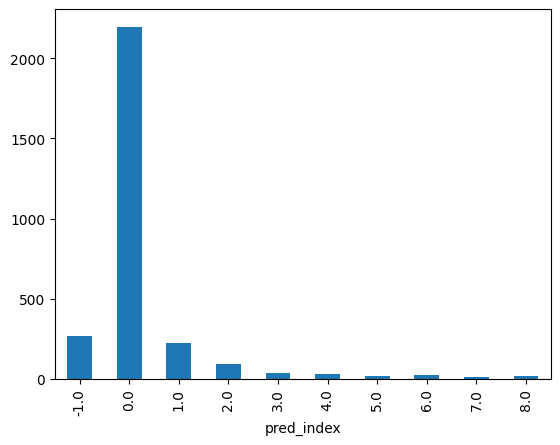

In [29]:
error_analysis.pred_index.value_counts().sort_index().iloc[0:10].plot.bar()